# Coffee Shop Sales Regression

1. Carga y previsualización del dataset (`.xlsx`).
2. Limpieza y extracción de features (fecha/hora → variables numéricas).
3. Cálculo de ventas por transacción y agrupación horaria por tienda.
4. Creación y entrenamiento de un modelo LinearRegression.
5. Predicción y comparación con ventas reales.
6. Gráficos en Matplotlib que comparan real vs. predicho.
7. Guardado de resultados finales.


---

Cargamos y previsualizamos el dataset

- Cree una variable por si necesito cambiar el dataset o si cambio de nombre al dataset.
- Con read leemos el dataset que tiene formato excel
- Se muestra tambien las primeras filas, dimensiones y nombres de las columnas

In [ ]:
import pandas as pd

file_path = 'Coffee-Shop-Sales.xlsx'

df = pd.read_excel(file_path)

print('\nShape:', df.shape)
print('Columns:', df.columns.tolist())
df.head()


Shape: (149116, 11)
Columns: ['transaction_id', 'transaction_date', 'transaction_time', 'transaction_qty', 'store_id', 'store_location', 'product_id', 'unit_price', 'product_category', 'product_type', 'product_detail']


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


Analizamos las columnas

In [12]:
df.info()

df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

---

#Extracción de Características Temporales a partir de Fechas y Horas de Transacción

Se encarga de convertir las fechas y horas de transacción en un formato datetime y extraer características temporales relevantes. 

1. **Conversión a Formato Datetime**: Se crea una nueva columna `datetime` combinando las columnas `transaction_date` y `transaction_time`. Se utiliza `pd.to_datetime` para convertir esta combinación en un objeto datetime, especificando el formato correspondiente.

2. **Extracción de Características Temporales**:
   - **Día de la Semana**: Se añade una columna `day_of_week` que representa el día de la semana (0 para lunes y 6 para domingo) utilizando el método `.dt.weekday`.
   - **Hora**: Se añade una columna `hour` que extrae la hora (0-23) del objeto datetime.
   - **Mes**: Se añade una columna `month` que extrae el mes (1-12) del objeto datetime.

3. **Visualización de Resultados**: Se imprime la lista de columnas del DataFrame después de la extracción de características y se muestran las primeras filas del DataFrame con las columnas relevantes.

In [15]:
df['datetime'] = pd.to_datetime(
    df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str)
)

df['day_of_week'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month

print('Columnas después de la extracción de características de fecha y hora', df.columns.tolist())
df[['transaction_date', 'transaction_time', 'datetime', 'day_of_week', 'hour', 'month']].head()

Columnas después de la extracción de características de fecha y hora ['transaction_id', 'transaction_date', 'transaction_time', 'transaction_qty', 'store_id', 'store_location', 'product_id', 'unit_price', 'product_category', 'product_type', 'product_detail', 'sales', 'datetime', 'day_of_week', 'hour', 'month']


,transaction_date,transaction_time,datetime,day_of_week,hour,month
0,2023-01-01,07:06:11,2023-01-01 07:06:11,6,7,1
1,2023-01-01,07:08:56,2023-01-01 07:08:56,6,7,1
2,2023-01-01,07:14:04,2023-01-01 07:14:04,6,7,1
3,2023-01-01,07:20:24,2023-01-01 07:20:24,6,7,1
4,2023-01-01,07:22:41,2023-01-01 07:22:41,6,7,1


---

#Análisis de Ventas por Hora y Ubicación de Tienda

Realiza un análisis de las ventas agrupadas por hora y ubicación de la tienda a partir de un DataFrame `df`.

1. **Cálculo de Ventas Totales**: Se crea una nueva columna `sales` que multiplica la cantidad de transacciones (`transaction_qty`) por el precio unitario (`unit_price`).

2. **Agrupación de Datos**: Se agrupan los datos por hora y ubicación de la tienda. Se utiliza `pd.Grouper(freq='H')` para agrupar por hora y se calcula la suma de las ventas totales.

3. **Renombrar Columnas**: Las columnas del DataFrame agrupado se renombran para mayor claridad, cambiando `datetime` a `datetime_hour` y `sales` a `total_sales_hour`.

4. **Extracción de Características Temporales**: Se añaden columnas adicionales que representan el día de la semana, la hora y el mes a partir de la columna `datetime_hour`.

5. **One-Hot Encoding**: Se aplica one-hot encoding a la columna `store_location` para convertir las ubicaciones de las tiendas en variables dummy, facilitando su uso en modelos de machine learning.

6. **Visualización de Resultados**: Finalmente, se imprime la lista de columnas del DataFrame resultante y se muestran las primeras filas del mismo.

In [ ]:
df['sales'] = df['transaction_qty'] * df['unit_price']

df_grouped = (
    df
    .copy()
    .set_index('datetime')
    .groupby([pd.Grouper(freq='h'), 'store_location'])
    .agg({'sales': 'sum'})
    .reset_index()
)

df_grouped = df_grouped.rename(columns={
    'datetime': 'datetime_hour',
    'sales': 'total_sales_hour'
})

df_grouped['day_of_week'] = df_grouped['datetime_hour'].dt.weekday
df_grouped['hour'] = df_grouped['datetime_hour'].dt.hour
df_grouped['month'] = df_grouped['datetime_hour'].dt.month

df_with_dummies = pd.get_dummies(df_grouped, columns=['store_location'], drop_first=True)

print('Columnas despues de agrupar y del one-hot encoding:', df_with_dummies.columns.tolist())
df_with_dummies.head()

Columnas despues de agrupar y del one-hot encoding: ['datetime_hour', 'total_sales_hour', 'day_of_week', 'hour', 'month', "store_location_Hell's Kitchen", 'store_location_Lower Manhattan']


,datetime_hour,total_sales_hour,day_of_week,hour,month,store_location_Hell's Kitchen,store_location_Lower Manhattan
0,2023-01-01 07:00:00,81.05,6,7,1,False,True
1,2023-01-01 08:00:00,43.30,6,8,1,True,False
2,2023-01-01 08:00:00,42.60,6,8,1,False,True
3,2023-01-01 09:00:00,83.85,6,9,1,True,False
4,2023-01-01 09:00:00,102.50,6,9,1,False,True


---

#Predicción de Ventas Horarias de Café

Creamos un modelo que predice las ventas de café por hora usando datos de ventas. Vamos a usar un modelo de regresión lineal para hacer esto.

1. Definir el Objetivo y las Características: definimos qué queremos predecir (nuestras ventas totales por hora) y qué datos vamos a usar para hacer esa predicción.

2. Preparamos los Datos: separamos nuestros datos en dos partes: una para entrenar el modelo y otra para probarlo.

3. Crear y Entrenar el Modelo: creamos el modelo de regresión lineal y entrenarlo con los datos de entrenamiento.

4. Hacer Predicciones: Usamos nuestro modelo para hacer predicciones sobre los datos de entrenamiento y prueba.

6. Evaluar el Modelo: Probamos qué tan bien está funcionando nuestro modelo usando algunas métricas.

7. Guardar el Modelo: Guardamos nuestro modelo entrenado para poder usarlo más tarde.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

target_col = 'total_sales_hour'
feature_cols = ['day_of_week', 'hour', 'month'] + [
    col
    for col in df_with_dummies.columns
    if col.startswith('store_location_')
]

X = df_with_dummies[feature_cols]
y = df_with_dummies[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'Train MSE: {mse_train:.2f}, R²: {r2_train:.3f}')
print(f'Test  MSE: {mse_test:.2f}, R²: {r2_test:.3f}')

joblib.dump(model, 'coffee_sales_hour_model.pkl')

Train MSE: 3601.74, R²: 0.348
Test  MSE: 3745.11, R²: 0.318


['coffee_sales_hour_model.pkl']

---

#Cargar el Modelo y Hacer Predicciones

Cargamos el modelo que guardamos anteriormente y usarlo para predecir las ventas en el conjunto de prueba. También creamos un DataFrame que muestre las características junto con las ventas reales y las predicciones.

1. Cargar Modelo Guardado: primero, cargamos el modelo que guardamos en el archivo.

2. Predecir sobre X_test: usamos el modelo cargado para hacer predicciones sobre el conjunto de prueba (X_test).

3. Construir DataFrame con Resultados: creamos un nuevo DataFrame que incluye las características de X_test, las ventas reales y las ventas predichas. También calculamos el error entre las ventas reales y las predicciones.

4. Mostrar Resultados: Mostramos las primeras filas del DataFrame con los resultados.


In [21]:
import joblib

model = joblib.load('coffee_sales_hour_model.pkl')

y_test_pred = model.predict(X_test)

df_results = X_test.copy().reset_index(drop=True)
df_results['sales_real'] = y_test.values
df_results['sales_predicted'] = y_test_pred
df_results['error'] = df_results['sales_real'] - df_results['sales_predicted']

df_results.head()

,day_of_week,hour,month,store_location_Hell's Kitchen,store_location_Lower Manhattan,sales_real,sales_predicted,error
0,5,13,2,True,False,28.50,71.573559,-43.073559
1,3,12,2,False,True,79.75,80.061821,-0.311821
2,1,14,2,False,False,32.85,76.035711,-43.185711
3,3,15,6,False,True,57.25,120.424099,-63.174099
4,2,17,6,True,False,87.90,104.536613,-16.636613


---

### Visualización de Ventas Reales vs Predichas

Creamos un gráfico que compare las ventas reales y las predichas para una ubicación específica de la tienda. Usaremos un gráfico de dispersión para mostrar cómo se comportan las ventas a lo largo de las horas del día.

1. Seleccionar Columnas de Ubicación: identificamos las columnas que representan las ubicaciones de las tiendas en nuestro DataFrame de resultados.

2. Filtrar Datos para una Ubicación: seleccionamos una de las ubicaciones y creamos una máscara para filtrar los datos correspondientes a esa ubicación.

3. Creamos el Gráfico

Usamos `matplotlib` para crear un gráfico de dispersión:
- Las ventas reales se mostrarán en azul.
- Las ventas predichas se mostrarán en rojo.

4. Configurar el Gráfico

Agregamos etiquetas a los ejes, un título y una leyenda para que el gráfico sea más informativo.

5. Guardar y Mostrar el Gráfico: guardamos el gráfico como un archivo PNG y lo mostramos en el notebook.


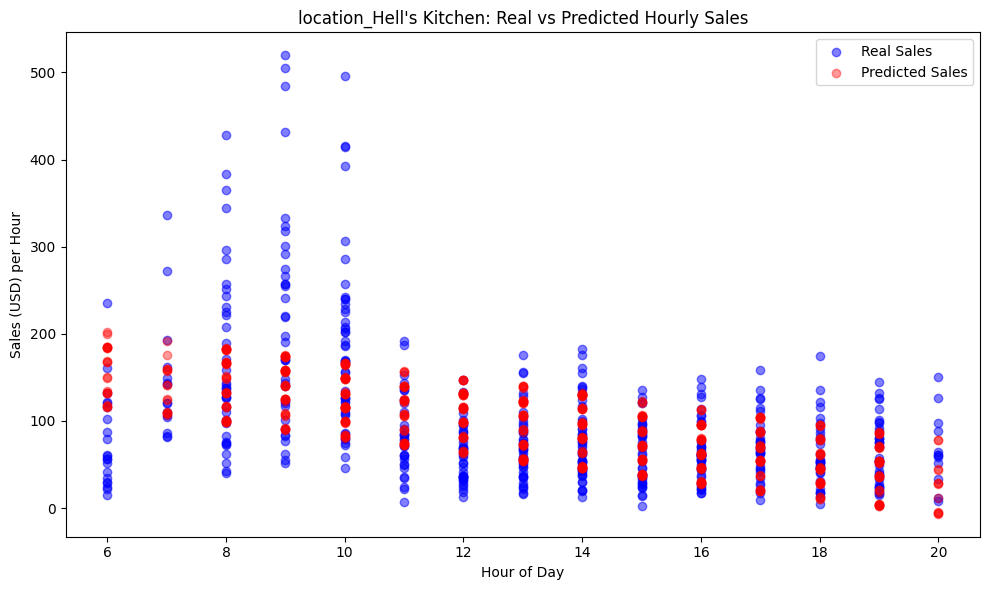

In [ ]:
import matplotlib.pyplot as plt

location_cols = [col for col in df_results.columns if col.startswith('store_location_')]

loc_col = location_cols[0]

mask_loc = df_results[loc_col] == 1

plt.figure(figsize=(10, 6))
plt.scatter(
    df_results.loc[mask_loc, 'hour'],
    df_results.loc[mask_loc, 'sales_real'],
    color='blue', alpha=0.5, label='Real Sales'
)
plt.scatter(
    df_results.loc[mask_loc, 'hour'],
    df_results.loc[mask_loc, 'sales_predicted'],
    color='red', alpha=0.4, label='Predicted Sales'
)

plt.xlabel('Hour of Day')
plt.ylabel('Sales (USD) per Hour')
plt.title(f'{loc_col.split('_',1)[1]}: Real vs Predicted Hourly Sales')
plt.legend()
plt.tight_layout()

output_png = f'hourly_sales_{loc_col.split('_',1)[1]}.png'
plt.savefig(output_png)
plt.show()

### Visualización de Ventas Promedio Reales vs Predichas

Creamos un gráfico de barras que compare las ventas promedio reales y las predichas por día de la semana.

1. **Agrupar Datos**: agrupamos los datos por día de la semana y calculamos la media de las ventas reales y predichas.

2. **Mapear Nombres de Días**: creamos un diccionario para mapear los números de los días de la semana a sus nombres correspondientes (por ejemplo, 0 a "Monday").

3. **Preparar el Gráfico**: definimos el ancho de las barras y la posición de cada barra en el gráfico.

4. **Crear el Gráfico de Barras**: usamos `matplotlib` para crear un gráfico de barras:
   - Las ventas reales se mostrarán en una barra.
   - Las ventas predichas se mostrarán en otra barra, al lado de la barra de ventas reales.

5. **Configurar el Gráfico**: agregamos etiquetas a los ejes, un título y una leyenda para que el gráfico sea más informativo.

6. **Guardar y Mostrar el Gráfico**: guardamos el gráfico como un archivo PNG y lo mostramos en el notebook.


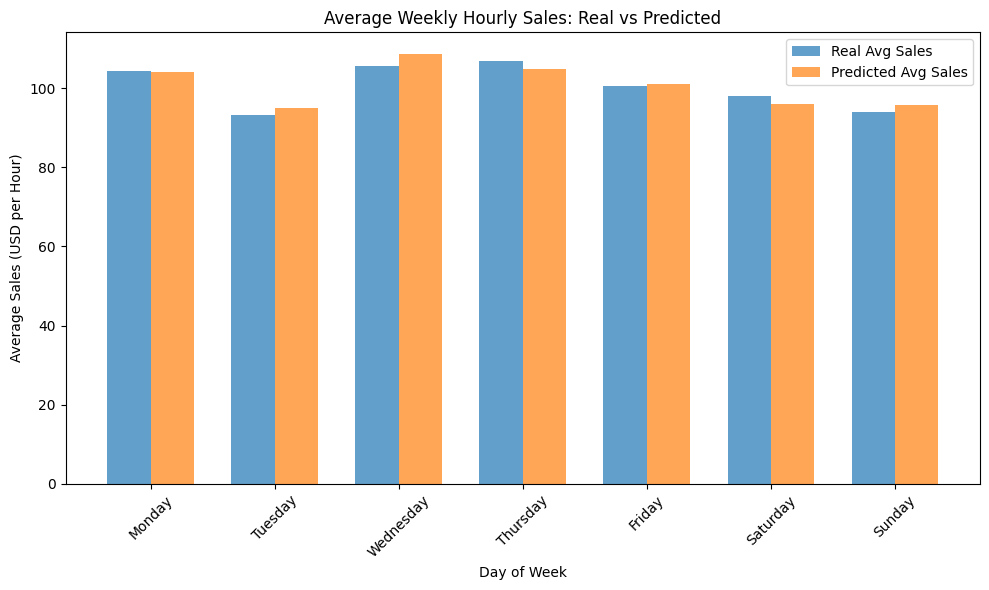

In [23]:
import matplotlib.pyplot as plt

df_bar = (
    df_results
    .groupby("day_of_week")
    .agg({
        "sales_real": "mean",
        "sales_predicted": "mean"
    })
    .reset_index()
)

days_map = {
    0: "Monday", 1: "Tuesday", 2: "Wednesday",
    3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"
}
df_bar["day_name"] = df_bar["day_of_week"].map(days_map)

x = range(len(df_bar))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar([i - width/2 for i in x], df_bar["sales_real"], width=width, label="Real Avg Sales", alpha=0.7)
plt.bar([i + width/2 for i in x], df_bar["sales_predicted"], width=width, label="Predicted Avg Sales", alpha=0.7)

plt.xticks(x, df_bar["day_name"], rotation=45)
plt.xlabel("Day of Week")
plt.ylabel("Average Sales (USD per Hour)")
plt.title("Average Weekly Hourly Sales: Real vs Predicted")
plt.legend()
plt.tight_layout()

plt.savefig("avg_sales_by_day_of_week.png")
plt.show()